In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score, matthews_corrcoef
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn import linear_model, neighbors
import pickle, time, glob, os, sys
from skimage.color import rgb2gray
import warnings
% matplotlib inline

In [2]:
# make feature vectors that have been transformed with fft
def read_photo_data(metadata_file="Photos_data_by_group.csv", data_col="Group", example_photo="./Fungi Pics/JL1.tif", sample=None):
    '''
    Function to read the photo metadata and extract important variables.
    
    Inputs:
    ------
    metadata_file : (str) Filepath to csv file that corresponds the photo to its classification.
    
    data_col : (str) Column of the file with the classifications.
    
    example_photo : (str) Filepath to an example photo for extracting dimensions.
    
    sample: (int, optional) Number of files to sample to reduce memory requirement.
    
    Outputs:
    -------
    photos_data : (dataframe) Dataframe containing photo filenames and label data.
    
    N : (int) Number of photos in dataset.
    
    labels : (array) Array of the labels associated with each photo.
    
    photo_filenames : (array) Array of the filenames of each photo.
    
    n_classes : (int) The number of unique labels in the dataset.
    
    h, w (int) : The dimensions (height and width) of the photos.
    
    '''
    photos_data = pd.read_csv(metadata_file)#[0:240] # Read the metadata file
    if sample != None:
        photos_data = photos_data.sample(n=sample)
    N = len(photos_data) # Find number of photos in dataset
    labels = np.array(photos_data[data_col]) # Extract photo labels from desired column
    photo_filenames = np.array(photos_data.File_name) # Extract filenames of photos
    n_classes = len(np.unique(labels)) # Find number of unique labels
    ex_photo = rgb2gray(plt.imread(example_photo)) # Read and convert an example photo to grayscale
    h, w = ex_photo.shape # Extract photo shape
    return photos_data, N, labels, photo_filenames, n_classes, h, w
def square_transform_rotate_flatten(im, square=True, rotate=True, fft=True):
    '''
    Function to square, fast Fourier transform, rotate, and flatten photos. Returns flat
    FFT image which has horizontal light-to-dark.
    Parameters:
    -----------
    im : (2D array) image to be squared, transformed, rotated if necessary, and flattened.
    
    Outputs:
    --------
    psd2D (2D array) image which has been squared, transformed, rotated if necessary, and flattened.
    '''
    h, w = im.shape[0:2]
    if h > w:
        h, w = w, h
    if fft:
        Fs = np.fft.fft2(im) # Perform fast Fourier transform
        F2 = np.fft.fftshift(Fs)  # Shift low frequencies to center and high frequencies to edges
        psd2D = np.abs(F2) # Remove imaginary component
        if square:
            psd2D_cen = psd2D[:,int((w-h)/2):int((w-(w-h)/2)+1)]
            mid = float(psd2D_cen[int(h/2),int(h/2)])
            ver = sum(psd2D_cen[int((h/2)-2):int((h/2)+3), int((h/2))])-mid
            hor = sum(psd2D_cen[int((h/2)), int((h/2)-2):int((h/2)+3)])-mid
            if abs(ver-hor) > .1 * np.mean([ver,hor]) and (ver>hor) and rotate:
                im = np.rot90(im)
                im = im[int((w-h)/2):int((w-(w-h)/2)+1),:]
            else:
                im = im[:,int((w-h)/2):int((w-(w-h)/2)+1)]
            Fs = np.fft.fft2(im) # Perform fast Fourier transform
            F2 = np.fft.fftshift(Fs)  # Shift low frequencies to center and high frequencies to edges
            psd2D = abs(F2)
        fft_int = psd2D.astype(int) # Convert values to integers to reduce RAM usage
    else:
        fft_int = im.astype(int)
    flat_psd = fft_int.flatten()
    return flat_psd#, im_orig, im, fft_int,
def get_fft_feat_vector(photo_filenames, photo_filepath, best_feats=None, fft=True):
    '''
    Function to create a feature vector of fft transformed photos.
    
    Inputs:
    ------
    photo_filenames : (array or array-like, contains strings) Array of all the filenames of photos to add to feature vector.
    
    photo_filepath : (str) The folder path preceding the photo filenames.
    
    best_feats : (list, or list-like, optional) The list of features to select from original vector.
    
    Outputs:
    -------
    fft_feature_vector : (2D array) The array of the features, size of (n_samples, n_features).
    '''
    start = time.time() # Initiates start time
    fft_feature_vector = [] # Empty list for storing feature vectors
    #print(photo_filenames)
    for i in photo_filenames:
        name = photo_filepath + i # Create filename to match with files in folder
        im = rgb2gray(plt.imread(name)) # Read in photo and convert to grayscale
        flat_psd = square_transform_rotate_flatten(im, square=False, rotate=False, fft=fft)
        if best_feats != None: # If feature selection is occuring
            flat_psd = flat_psd[best_feats] # Select best features
        fft_feature_vector.append(flat_psd) # Append image vector to list
    fft_feature_vector = np.array(fft_feature_vector) # Convert list to array
    Runtime = time.time()-start # Calculate total runtime
    print("Time to make feature vectors:", Runtime)
    print(sys.getsizeof(fft_feature_vector)) # Print size of feature vectors
    return fft_feature_vector

def estimate_best_forest(train_vectors, train_labels, test_vectors, test_labels, stop_score, stop_time, thresh_score=0, extract_features=False, pickled_classifier="hyphal_image_RF_classifier2.obj"):
    '''
    Function to find best Random Forest Classifier through repeated generation of classifiers.
    
    Inputs:
    -------
    train_vectors : A two dimensional array of the features of a dataset to classify after being split into training
    and testing data.
    
    train_labels : A one dimensional array of the labels corresponding to the features in the training dataset.
    
    test_vectors : A two dimensional array of the features of a dataset to classify after being split into training
    and testing data.
    
    test_labels : A one dimensional array of the labels corresponding to the features in the testing dataset.
    
    stop_score : (float) The weighted f1-score which if achieved stops the generation of new classifiers.
    
    stop_time : (integer) The maximum time for whch new classifiers are generated, in seconds.
    
    thresh_score : (float) The threshold f1-score beyond which the features of a classifier are saved.
    
    extract_features : (=True, Boolean, optional) Whether to save best features and return them as output.
    
    pickled_classifier : (="hyphal_image_RF_classifier2.obj", string) File location to store classifier object
    
    Outputs:
    -------
    clf : RandomForestClassifier object wih best score of those generated.
    
    f_scores : List of all the classifiers' weighted f1-scores.
    
    best_feats : List of the features used by classifiers beyond the threshold score.
    '''
    start = time.time() # Initiates start time
    Runtime = 0 # Assigns Runtime variable to zero
    f_scores_int = [] # Creates empty list for storing f1-scores
    best_feats = [] # Creates empty list to store features of best classifiers
    clf = RandomForestClassifier() # Creates instance of classifier object
    #clf = clf.fit(train_vectors, train_labels) # Fits the classifier object
    #pred_labels = clf.predict(test_vectors) # Predicts labels for the testing set
    best_score = 0 #f1_score(test_labels, pred_labels, average='weighted') # Assigns initial best f1-score
    while best_score < stop_score and Runtime < stop_time:
        # Generates classifiers while score is below stop_score and Runtime is less than stop_time
        clf_temp = clf.fit(train_vectors, train_labels) # Finds a new random forest
        pred_labels = clf_temp.predict(test_vectors) # Predicts labels
        temp_score = f1_score(test_labels, pred_labels, average='weighted') # Determines score of new classifier
        f_scores_int.append(temp_score) # Append score to list
        if temp_score > best_score: # If score is better than the previous best
            clf = clf_temp # Temporary classifier saved as new classifier
            pickle.dump(clf_temp, open(pickled_classifier, "wb")) # Store new classifier
            best_score = temp_score # Set new best score
            print(best_score, Runtime) # Print the score and runtime
        if temp_score > thresh_score and extract_features: # If score is above thresh_score and extract_features is true
            best_feats.extend(extract_imp_feats(clf_temp)) # Append best features to list
        Runtime = time.time()-start # Calculate total runtime
    clf = pickle.load(open(pickled_classifier, "rb")) # Load best classifier
    pred_labels = clf.predict(test_vectors) # Predicts the labels using best classifier
    print(classification_report(test_labels, pred_labels)) # Prints the classification report
    print(confusion_matrix(test_labels, pred_labels)) # Prints the confusion matrix
    if extract_features: # If extract features is true
        return clf, f_scores_int, best_feats # Returns the classifier, f1-score list, and best features
    else:
        return clf, f_scores_int # Returns the classifier and f1-score list

def extract_imp_feats(clf):
    '''
    Function to extract the important features of a classifier and return their indexes.
    
    Inputs:
    ------
    clf : RandomForestClassifier object
    
    Outputs:
    -------
    imp_feats_ind : (list) indices of important features
    '''
    feat_imps = clf.feature_importances_ # store all feature importances of the classifier
    imp_feats = np.sum(feat_imps > 0) # Obtains the number of non-zero feature importances
    imp_feat_indices = np.argsort(feat_imps)[-(imp_feats-10):] # Sort and extract the most important feature indexes
    return imp_feat_indices

def plot_important_feats(best_feats, h, w, plot_type='scatter'):
    '''
    Plotting function to plot indexes of a flattened array. Plots as either scatterplot or 2D histogram.
    
    Inputs:
    ------
    best_feats : (array, or array-like) Array of the indexes of points to plot.
    
    h, w : (int) Shape of pre-flattened array.
    
    plot_type : (str, optional) Type of plot to display. Either 'scatter' or 'hist'.
    '''
    best_feats_array = np.array(best_feats) # Converts input to array
    # Acquires coordinates for given indexes
    x = np.floor(best_feats_array/h) # Round down to find column index
    y = np.mod(best_feats_array, w) # Modulus to find row index
    if plot_type == 'scatter': # Plots a scatterplot
        plt.scatter(x, y, s=1)
    elif plot_type == 'hist': # Plots a 2D histogram
        plt.hist2d(x, y, bins=50)
        
def get_f_score_stats(f_scores, percentile = 95):
    '''
    Function for displaying statistics and histogram of a distribution.
    
    Inputs:
    ------
    f_scores : (list, or list-like) List of floats of which to get summary statistics and histogram.
    
    percentile : (float, 0-100, optional) Percentile at which to get the threshold score.
    
    Outputs:
    -------
    thresh_score : (float) Value which falls at the specified percentile.
    '''
    print("Mean:", np.mean(f_scores)) # Print mean of values
    print("Median:", np.median(f_scores)) # Print median of values
    print("Count:", len(f_scores)) # Print number of values
    print("Standard Deviation:", np.std(f_scores)) # Print standard deviation of values
    thresh_score = np.percentile(f_scores, percentile)
    print("Threshold score:", thresh_score)
    plt.hist(f_scores, bins = 30)
    return thresh_score

In [9]:
photos_data, N, labels, photo_filenames, n_classes, h, w = read_photo_data(sample=200)

In [6]:
print(len(labels))
a_count = 0
m_count = 0
for i in labels:
    if i == 1:
        m_count+=1
    elif i == 2:
        a_count += 1
print(m_count, a_count)

564
398 166


In [5]:
plt.figure(figsize=(12,12))
im = rgb2gray(plt.imread('./Fungi Pics/JL037_009.tif'))
im_orig, im, fft_int, flat_psd = square_transform_rotate_flatten(im)
plt.subplot(131)
plt.imshow(im_orig)

plt.subplot(132)
plt.imshow(im)

plt.subplot(133)
plt.imshow(np.log(fft_int))

ValueError: too many values to unpack (expected 4)

In [12]:
labels

[2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 1,
 2,
 2,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 1,
 2,
 2,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 2,
 1,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 1,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 2,
 2,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 1,
 2,
 2,
 1,
 1,
 2,
 1]

In [11]:
new_labels = []
for i in labels:
    if "Clade" in i:
        new_labels.append(1)
    else:
        new_labels.append(2)
labels = new_labels

In [13]:
fft_feature_vector = get_fft_feat_vector(photo_filenames, './Fungi Pics/')
fft_train_vectors, fft_test_vectors, fft_train_labels, fft_test_labels = train_test_split(fft_feature_vector, 
                                                                          labels, random_state=324507, test_size=0.50)

Time to make feature vectors: 155.18748426437378
2516582512


In [6]:
n_components = 20
fft_pca = PCA(n_components=n_components, whiten=True)
_ = fft_pca.fit(fft_train_vectors)
pickle.dump(fft_pca, open("hyphal_image_pca.obj", "wb"))
pca_fft_feature_vector = fft_pca.transform(fft_feature_vector)
#for i in pca_fft_feature_vector:
#    pca_fft_feature_vector = i[best_feats]
pca_fft_train_vectors, pca_fft_test_vectors, fft_train_labels, fft_test_labels = train_test_split(pca_fft_feature_vector, 
                                                                          labels, random_state=324507, test_size=0.50)

In [7]:
pca_fft_feature_vector.shape

(200, 20)

In [6]:
pickle.dump(fft_feature_vector, open("fft_feature_vectors.obj", "wb"))

In [8]:
clf, f_scores, best_feats = estimate_best_forest(pca_fft_train_vectors, fft_train_labels, pca_fft_test_vectors,
                                    fft_test_labels, 0.99, 900, 0.83, extract_features=True)

0.803125 0.4027557373046875
0.820662768031 0.6907444000244141
0.828812537673 4.72252345085144
0.829630243741 10.05170226097107
0.833970377449 25.630160570144653
0.837781868385 26.731085777282715
0.838753387534 36.56926155090332
0.86875 45.124101638793945


C:\Users\julia\Anaconda3\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\julia\Anaconda3\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\julia\Anaconda3\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\julia\Anaconda3\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\julia\Anaco

0.871609403255 733.3917229175568
0.893007836046 803.5794837474823
             precision    recall  f1-score   support

          1       0.89      0.99      0.94        75
          2       0.94      0.64      0.76        25

avg / total       0.90      0.90      0.89       100

[[74  1]
 [ 9 16]]


Mean: 0.748537560802
Median: 0.746612466125
Count: 58917
Standard Deviation: 0.0309776669647
Threshold score: 0.798245614035


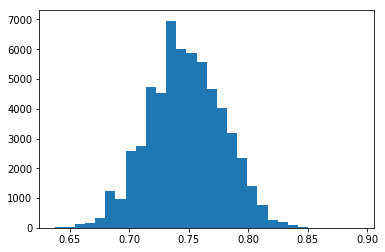

In [11]:
thresh_score = get_f_score_stats(f_scores)

In [9]:
clf, f_scores, best_feats = estimate_best_forest(fft_train_vectors, fft_train_labels, fft_test_vectors,
                                    fft_test_labels, 0.99, 3600, thresh_score, True)

0.777665806307 22.1565420627594
0.824872288538 40.83571815490723
0.829103177524 340.2543637752533
0.832345795495 1643.8391082286835
             precision    recall  f1-score   support

          1       0.90      0.86      0.88        71
          2       0.69      0.76      0.72        29

avg / total       0.84      0.83      0.83       100

[[61 10]
 [ 7 22]]


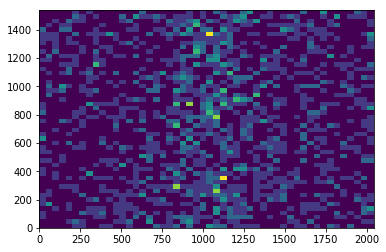

In [11]:
plot_important_feats(best_feats, h, h, 'hist')

In [13]:
pickle.dump(best_feats, open("best_features_mm.obj", "wb"))

In [12]:
len(best_feats)

1517

In [22]:
clf, best_feats = pickle.load(open("hyphal_image_RF_classifier2.obj", 'rb')), pickle.load(open("best_features.obj", 'rb'))

In [14]:
'''
photos_data, N, labels, photo_filenames, n_classes, h, w = read_photo_data()
new_labels = []
for i in labels:
    if "Mucor" in i:
        new_labels.append("Mucor")
    else:
        new_labels.append("Mortierella")
labels = new_labels
'''
photos_data, N, labels, photo_filenames, n_classes, h, w = read_photo_data()
fft_feature_vector = get_fft_feat_vector(photo_filenames, './Fungi Pics/', best_feats)
fft_train_vectors, fft_test_vectors, fft_train_labels, fft_test_labels = train_test_split(fft_feature_vector, 
                                                                          labels, random_state=324507, test_size=0.50)

Time to make feature vectors: 407.09626173973083
3422464


In [15]:
clf, f_scores = estimate_best_forest(fft_train_vectors, fft_train_labels, fft_test_vectors,
                                    fft_test_labels, 0.99, 600, 0, extract_features = False)

0.79419463235 0.9822211265563965
0.798741905643 5.699821472167969
0.818755601842 7.888740062713623
0.826153332379 156.49126148223877
             precision    recall  f1-score   support

          1       0.84      0.93      0.89       195
          2       0.80      0.61      0.69        87

avg / total       0.83      0.83      0.83       282

[[182  13]
 [ 34  53]]


Mean: 0.751174384931
Median: 0.751521553242
Count: 11039
Standard Deviation: 0.0227336305354
Threshold score: 0.787003504522


0.78700350452215828

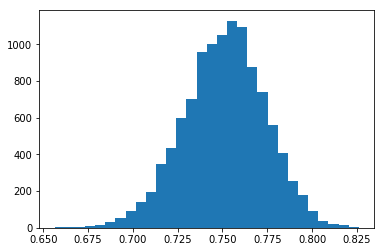

In [16]:
get_f_score_stats(f_scores)

In [44]:
scores = cross_val_score(clf, fft_feature_vector, labels, cv=5)
print(scores)

[ 0.7804878   0.7804878   0.8         0.71794872  0.79487179]


In [45]:
pickle.dump(clf, open("hyphal_image_RF_classifier3.obj", 'wb'))
#pickle.dump(best_feats, open("best_features.obj", 'wb'))

In [6]:
# create feature vectors without fft
feature_vector = []
for i in photo_filenames:
    name = './Fungi Pics/' + i
    im = rgb2gray(plt.imread(name))
    flat_im = im.flatten()
    feature_vector.append(flat_im)
feature_vector = np.array(feature_vector)

In [7]:
feature_vector.shape

(173, 3145728)

In [8]:
# split into testing and training data
train_vectors, test_vectors, train_labels, test_labels = train_test_split(feature_vector, 
                                                                          labels, 
                                                                          random_state=1,
                                                                          test_size=0.5)

In [6]:
# run principal components analysis
n_components = 10
pca = PCA(n_components=n_components, whiten=True)
_ = pca.fit(train_vectors)

In [7]:
# run SVM on PCS transformed images without fft
pca_train_vectors = pca.transform(train_vectors)
pca_test_vectors = pca.transform(test_vectors)
start = time.time()
print("Fitting the classifier to the training set")
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(pca_train_vectors, train_labels)
print("Best estimator found by grid search:")
print(clf.best_estimator_)

#pickle.dump(clf, open(PCA_test_5comp, 'wb'))
end = time.time()
print("Runtime:", end-start)
pred_labels = clf.predict(pca_test_vectors)
print(n_components, classification_report(test_labels, pred_labels))
print(n_components, confusion_matrix(test_labels, pred_labels, labels=range(n_classes)))

Fitting the classifier to the training set
Best estimator found by grid search:
SVC(C=5000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Runtime: 0.4732656478881836
10              precision    recall  f1-score   support

          1       0.69      0.34      0.46        32
          2       0.50      0.81      0.62        26

avg / total       0.60      0.55      0.53        58

10 [[ 0  0]
 [ 0 11]]


In [82]:
# make feature vectors that have been transformed with fft
def get_fft_feat_vector(photo_filepath,n_photos, select_best_features):
    fft_feature_vector = []
    for i in photo_filenames[:n_photos+1]:
        name = photo_filepath + i
        im = rgb2gray(plt.imread(name))
        gim = rgb2gray(im)
        Fs = np.fft.fft2(gim)
        F2 = np.fft.fftshift(Fs) 
        psd2D = np.abs(F2)
        fft_int = psd2D.astype(int)
        flat_psd = fft_int.flatten()
        if select_best_features:
            flat_psd = flat_psd[best_feats]
        fft_feature_vector.append(flat_psd)
    fft_feature_vector = np.array(fft_feature_vector)
    print(sys.getsizeof(fft_feature_vector))
    return fft_feature_vector

In [114]:
fft_feature_vector = get_fft_feat_vector('./Fungi Pics/', N, True)

627096


In [115]:
# split fft vectors and labels into training and testing data
fft_train_vectors, fft_test_vectors, fft_train_labels, fft_test_labels = train_test_split(fft_feature_vector, 
                                                                          labels, 
                                                                          random_state=324507,
                                                                          test_size=0.50)

In [45]:
#del fft_feature_vector

In [17]:
# run PCA on fft data
n_components = 20
fft_pca = PCA(n_components=n_components, whiten=True)
_ = fft_pca.fit(fft_train_vectors)
pickle.dump(fft_pca, open("hyphal_image_pca.obj", "wb"))

In [18]:
pca_fft_train_vectors = fft_pca.transform(fft_train_vectors)
pca_fft_test_vectors = fft_pca.transform(fft_test_vectors)

In [21]:
clf, f_scores = estimate_best_forest(pca_fft_train_vectors, fft_train_labels, pca_fft_test_vectors,
                                    fft_test_labels, 0.99, 600, 0, extract_features = False)

0.832016632017 0.1354055404663086
0.836507936508 0.22658085823059082
0.850666666667 0.6863689422607422
0.857544152413 5.10532021522522
0.867942583732 6.017749309539795
0.883616265298 11.40642523765564
0.885354896676 48.600813150405884
0.897817460317 204.72114658355713
             precision    recall  f1-score   support

          1       0.91      0.96      0.93        70
          2       0.88      0.77      0.82        30

avg / total       0.90      0.90      0.90       100

[[67  3]
 [ 7 23]]


In [27]:
clf, f_scores, best_feats = estimate_best_forest(pca_fft_train_vectors, fft_train_labels, pca_fft_test_vectors,
                                    fft_test_labels, 0.99, 600, 0, extract_features = True)

0.795593999189 0
0.796503496503 0.19667625427246094
0.808 0.35795116424560547
0.820134228188 0.5324170589447021
0.843665768194 0.5901350975036621
0.850666666667 1.127519130706787
0.853014553015 11.521423578262329
0.864510332435 12.446850538253784


KeyboardInterrupt: 

In [7]:
#run SVM on PCA transformed fft data
pca_fft_train_vectors = fft_pca.transform(fft_train_vectors)
pca_fft_test_vectors = fft_pca.transform(fft_test_vectors)
start = time.time()
print("Fitting the classifier to the training set")
param_grid = {'C': [10, 1e2, 1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.00001, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(pca_fft_train_vectors, fft_train_labels)
print("Best estimator found by grid search:")
print(clf.best_estimator_)

pickle.dump(clf, open("hyphal_image_classifier.obj", "wb"))
end = time.time()
print("Runtime:", end-start)
pred_labels = clf.predict(pca_fft_test_vectors)
print(n_components, classification_report(fft_test_labels, pred_labels))

Fitting the classifier to the training set
Best estimator found by grid search:
SVC(C=50000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Runtime: 0.8051292896270752
20              precision    recall  f1-score   support

          1       0.95      0.76      0.85        72
          2       0.60      0.89      0.71        28

avg / total       0.85      0.80      0.81       100



In [193]:
# Run Random Forest Classifier to find best f1-score
def estimate_best_forest(train_vectors, train_labels, test_vectors, test_labels, stop_score, stoptime, thresh_score, extract_features=True):
    start = time.time()
    Runtime = 0
    f_scores_int = []
    clf2 = RandomForestClassifier()
    clf2 = clf2.fit(train_vectors, train_labels)
    pred_labels2 = clf2.predict(test_vectors)
    best_score = f1_score(test_labels, pred_labels2, average='weighted')
    best_feats = []
    while f1_score(test_labels, pred_labels2) < stop_score and Runtime < stoptime:
        clf_temp = clf2.fit(train_vectors, train_labels)
        pred_labels2 = clf_temp.predict(test_vectors)
        temp_score = f1_score(test_labels, pred_labels2, average='weighted')
        f_scores_int.append(temp_score)
        if temp_score > best_score:
            clf2 = clf_temp
            pickle.dump(clf_temp, open("hyphal_image_RF_classifier2.obj", "wb"))
            best_score = temp_score
            print(best_score, Runtime)
        if temp_score > thresh_score and extract_features:
            best_feats.extend(extract_imp_feats(clf_temp))
        end = time.time()
        Runtime = end-start
    clf2 = pickle.load(open("hyphal_image_RF_classifier2.obj", 'rb'))
    pred_labels2 = clf2.predict(test_vectors)
    print(classification_report(test_labels, pred_labels2))
    plt.hist(f_scores_int)
    if extract_features:
        return f_scores_int, best_feats
    else:
        return f_scores_int

In [ ]:
f_scores_int = estimate_best_forest(fft_train_vectors, fft_train_labels, fft_test_vectors, fft_test_labels, 0.99, 600, 0, extract_features = False)

0.910995670996 0
0.912087912088 1.0086219310760498
0.921589688507 5.4488325119018555
0.922616374794 11.564260244369507
0.934065934066 23.060418128967285


In [43]:
clf2 = pickle.load(open("hyphal_image_RF_classifier2.obj", 'rb'))
pred_labels = clf2.predict(fft_test_vectors)
print(classification_report(fft_test_labels, pred_labels))
print(confusion_matrix(fft_test_labels, pred_labels))

             precision    recall  f1-score   support

          1       0.98      0.95      0.97        65
          2       0.89      0.96      0.93        26

avg / total       0.96      0.96      0.96        91

[[62  3]
 [ 1 25]]


In [121]:
# data on distribution of f1 scores
print(np.std(f_scores_int))
print(np.median(f_scores_int))
print(len(f_scores_int))
print(np.argmax(f_scores_int))
print((0.94 - np.mean(f_scores_int))/np.std(f_scores_int))

0.0260081017495
0.854380850084
32772
11408
3.28804841994


In [31]:
test_pic = np.reshape(fft_feature_vector[0], (1,-1))
print(clf2.decision_path(test_pic))

(<1x90 sparse matrix of type '<class 'numpy.int64'>'
	with 32 stored elements in Compressed Sparse Row format>, array([ 0,  9, 18, 27, 38, 47, 56, 67, 76, 83, 90], dtype=int32))


Text(0.5,1,'Distribution of Random Forest Classifiers')

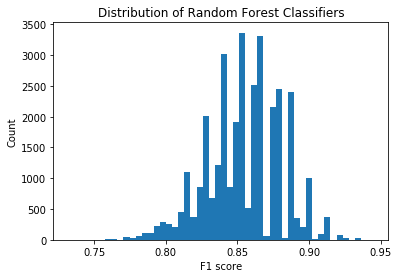

In [122]:
plt.hist(f_scores_int, bins=50);
plt.xlabel("F1 score")
plt.ylabel("Count")
plt.title("Distribution of Random Forest Classifiers")

In [79]:
pickle.dump(clf2, open("hyphal_image_RF_classifier_updated.obj", "wb"))

In [25]:
clf2 = pickle.load(open("hyphal_image_RF_classifier2.obj", 'rb'))

pred_labels = clf2.predict(pca_fft_test_vectors)
print(f1_score(fft_test_labels, pred_labels, average='weighted'))
print(matthews_corrcoef(fft_test_labels, pred_labels))
print(classification_report(fft_test_labels, pred_labels))
print(confusion_matrix(fft_test_labels, pred_labels))

0.897817460317
0.756190830297
             precision    recall  f1-score   support

          1       0.91      0.96      0.93        70
          2       0.88      0.77      0.82        30

avg / total       0.90      0.90      0.90       100

[[67  3]
 [ 7 23]]


Mean: 0.782680330598
Median: 0.78407523511
Count: 37470
Standard Deviation: 0.0319622409788
Threshold score: 0.832016632017


0.83201663201663212

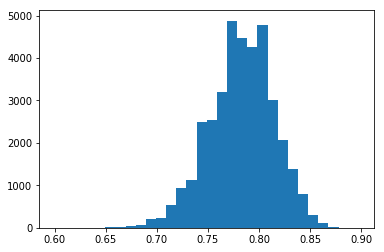

In [26]:
get_f_score_stats(f_scores)

In [188]:
def extract_imp_feats(clf):
    '''
    Function to extract the important features of a classifier and return their indexes.
    Inputs:
    clf, a RandomForestClassifier object
    Outputs:
    indices of important features
    '''
    feat_imps = clf.feature_importances_
    imp_feats = np.sum(feat_imps > 0)
    imp_feat_indices = np.argsort(feat_imps)[-imp_feats:]
    return list(imp_feat_indices)

def get_coords(index, h, w):
    x = np.floor(index/h)
    y = np.mod(index, w)
    return np.vstack((x, y))

In [205]:
def plot_important_feats(best_feats, clf, h, w, plot_type='scatter'):
    best_feats_array = np.array(best_feats)
    sup_feats = best_feats_array[extract_imp_feats(clf)]
    coords = get_coords(best_feats_array, h, w)
    im = np.zeros(h*w)
    im = im.reshape((h,w))
    if plot_type == 'scatter':
        plt.scatter(coords[0],coords[1], s=1)
    elif plot_type == 'hist':
        plt.hist2d(coords[0],coords[1], bins=20)

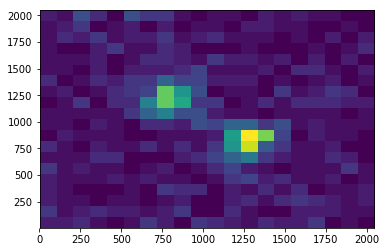

In [206]:
plot_important_feats(best_feats, clf2, h, w, 'hist')

In [71]:
pickle.dump(clf2, open("hyphal_image_RF_classifier2.obj", "wb"))

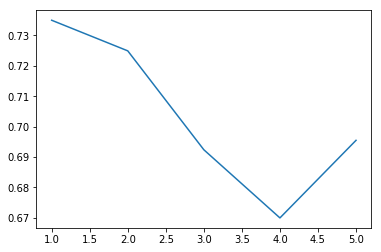

In [11]:
iterations = [1,2,3,4,5]
f1_scores_perc = []
for i in iterations:
    clf5 = neighbors.KNeighborsClassifier(n_neighbors=i)
    clf5.fit(fft_train_vectors, fft_train_labels)
    pred_labels5 = clf5.predict(fft_test_vectors)
    f1_scores_perc.append(f1_score(fft_test_labels, pred_labels5, average='weighted'))
#print(classification_report(fft_test_labels, pred_labels))
plt.plot(iterations, f1_scores_perc)

Text(0.5,1,'Principal Components Analysis')

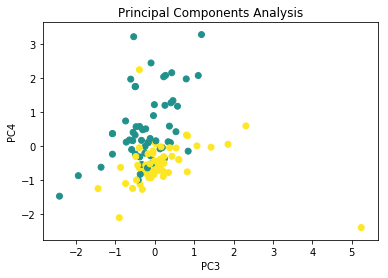

In [75]:
# plotting of principle components
n1 = 2
n2 = 3
plt.scatter(pca_fft_test_vectors[:,n1], pca_fft_test_vectors[:,n2], c=test_labels, cmap='viridis', vmin = 0, vmax = 2)
plt.scatter(pca_fft_train_vectors[:,n1], pca_fft_train_vectors[:,n2], c=train_labels, cmap='viridis', vmin=0, vmax = 2)
plt.xlabel('PC'+str(n1+1))
plt.ylabel('PC'+str(n2+1))
plt.title("Principal Components Analysis")

In [106]:
def photo_transform(im_name):
    '''
    Reads the image file and applies fast Fourier transform, then flattens it for use by the PCA and SVM algorithms.
    Input: image name, such as "./Fungi Pics/JU-15B.tif".
    Output: flattened and 2D array of frequency space
    '''
    im = imread(im_name, flatten=True) # read image and converts it to gray
    Fs = np.fft.fft2(im) # run fast Fourier transform on gray image
    F2 = np.fft.fftshift(Fs) # move the zero frequency component to the center
    psd2D = np.abs(F2) # remove imaginary values
    flat_psd = psd2D.flatten() # flatten the array
    flat_psd = flat_psd.reshape((1, -1)) # make it 2D for PCA and SVM
    return flat_psd
def photo_pred(flat_psd):
    '''
    Makes a prediction of which class the fungi is in when given a transformed image.
    Input: flattened 2D fft image from photo_transform
    Output: class prediction
    '''
    pca = pickle.load(open("hyphal_image_pca.obj", 'rb')) # load up-to-data PCA and SVM classifier
    clf = pickle.load(open("hyphal_image_classifier.obj", 'rb'))
    pca_psd = pca.transform(flat_psd) # transform with the PCA
    pred_label = clf.predict(pca_psd) # predict with the SVM
    if pred_label == 1: # return prediction decision
        return "Zygomycete"
    if pred_label == 2:
        return "Ascomycete or Basidiomycete"
def main(im_name):
    flat_psd = photo_transform(im_name)
    pred_label = photo_pred(flat_psd)
    print(pred_label)

(1536, 2048, 3)
Vert: 2308662.48723
Horz: 3353480.50563


Text(0.5,1,'FFT Image')

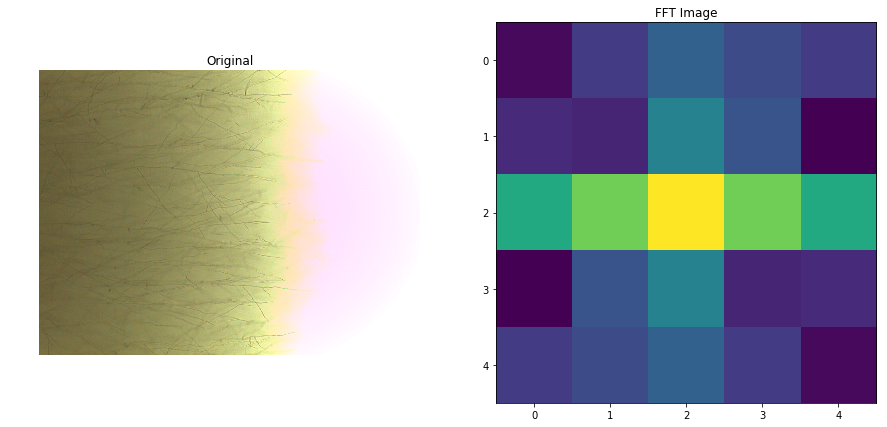

In [40]:
im = plt.imread("./Fungi Pics/JU-25.tif")
print(im.shape)
gim = rgb2gray(im) # Read in photo and convert to grayscale
Fs = np.fft.fft2(gim) # Perform fast Fourier transform
F2 = np.fft.fftshift(Fs)  # Shift low frequencies to center and high frequencies to edges
psd2D = np.abs(F2) # Remove imaginary component
fft_int = psd2D.astype(int) # Convert values to integers to reduce RAM usage
flat_psd = fft_int.flatten() # flatten the array
flat_psd = flat_psd.reshape((1, -1))
plt.figure(figsize=(15,8))
plt.subplot(121)
plt.imshow(im)
plt.axis('off')
plt.title("Original")

plt.subplot(122)
plt.imshow(np.log(psd2D)[766:771, 1022:1027], cmap='viridis')
print("Vert:", sum(psd2D[766:771, 1024]))
print("Horz:", sum(psd2D[768, 1022:1027]))
plt.axis()
plt.title("FFT Image")
#clf = pickle.load(open('hyphal_image_RF_classifier.obj', 'rb'))
#plt.suptitle("Predicted Class: " + str(clf.predict(flat_psd)), y=0.8)
#plt.savefig("hyphal_image_classification.png")

(1536, 1536, 3)
foo
(1536, 1536)
Vert: 1538285.63104
Horz: 1727553.32342


Text(0.5,1,'FFT Image')

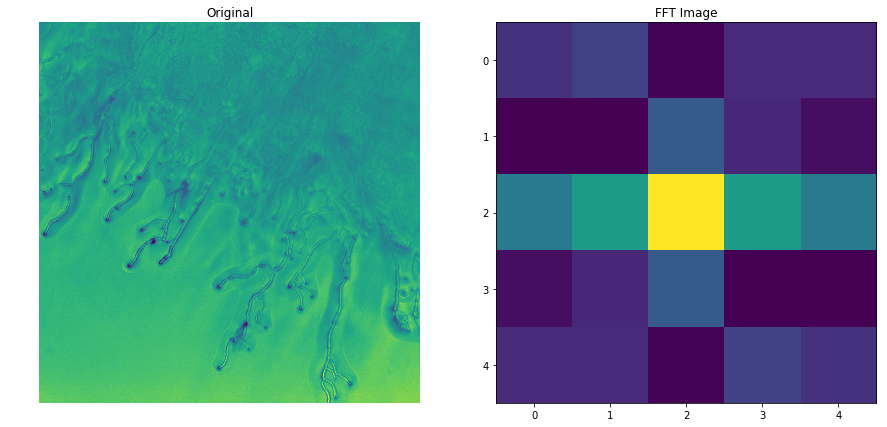

In [68]:
im = plt.imread("./Fungi Pics/JU-50.tif")[:,256:1792]
print(im.shape)
gim = rgb2gray(im)# Read in photo and convert to grayscale
Fs = np.fft.fft2(gim) # Perform fast Fourier transform
F2 = np.fft.fftshift(Fs)  # Shift low frequencies to center and high frequencies to edges
psd2D = np.abs(F2) # Remove imaginary component
fft_int = psd2D.astype(int) # Convert values to integers to reduce RAM usage
ver = sum(psd2D[766:771, 768])
hor = sum(psd2D[768, 766:771])
if abs(ver-hor) > .1 * np.mean([ver,hor]) and (ver>hor):
    print("foo")
    psd2D = np.rot90(psd2D)
flat_psd = fft_int.flatten() # flatten the array
flat_psd = flat_psd.reshape((1, -1))
plt.figure(figsize=(15,8))
plt.subplot(121)
plt.imshow(gim)
plt.axis('off')
plt.title("Original")
print(psd2D.shape)
plt.subplot(122)
plt.imshow(np.log(psd2D)[765:770, 766:771], cmap='viridis')
print("Vert:", sum(psd2D[765:770, 768]))
print("Horz:", sum(psd2D[767, 766:771]))
plt.axis()
plt.title("FFT Image")

In [72]:
def square_transform_rotate_flatten(im):
    '''
    Function to square, fast Fourier transform, rotate, and flatten photos. Returns flat
    FFT image which has horizontal light-to-dark.
    Parameters:
    -----------
    im : (2D array) image to be squared, transformed, rotated if necessary, and flattened.
    
    Outputs:
    --------
    psd2D (2D array) image which has been squared, transformed, rotated if necessary, and flattened.
    '''
    h, w = im.shape[0:2]
    if h > w:
        h, w = w, h
    Fs = np.fft.fft2(im) # Perform fast Fourier transform
    F2 = np.fft.fftshift(Fs)  # Shift low frequencies to center and high frequencies to edges
    psd2D = np.abs(F2) # Remove imaginary component
    psd2D = psd2D[:,(w-h)/2:(w-(w-h)/2)+1]
    ver = sum(psd2D[(h/2)-2:(h/2)+3, (h/2)])
    hor = sum(psd2D[(h/2), (h/2)-2:(h/2)+3])
    if abs(ver-hor) > .1 * np.mean([ver,hor]) and (ver>hor):
        psd2D = np.rot90(psd2D)
    fft_int = psd2D.astype(int) # Convert values to integers to reduce RAM usage
    flat_psd = fft_int.flatten()
    return flat_psd

In [14]:
from sklearn.neural_network import MLPClassifier
#for i in [10, 20, 30, 40, 50, 60, 70, 100]:
    #clf = MLPClassifier(solver='lbfgs', alpha=1e-2, hidden_layer_sizes=(i))
    #start = time.time()
    #clf.fit(pca_fft_train_vectors, fft_train_labels)
    #pred_labels = clf.predict(pca_fft_test_vectors)
    #print(time.time()-start)
    #print(i, j)
    #print(classification_report(fft_test_labels, pred_labels))
    #print(confusion_matrix(fft_test_labels, pred_labels))

In [15]:
class rand_for_base():
    def __init__(self, runtime=300):
        self.clf_base = RandomForestClassifier()
        self.f_scores = []
        self.runtime = runtime
class pca_iter_rand_for(rand_for_base):
    def fit(self, train_vec, train_labels, test_vec, test_labels):
        n_components = 20
        self.fft_pca = PCA(n_components=n_components, whiten=True)
        _ = self.fft_pca.fit(train_vec)
        pca_train_vector = self.fft_pca.transform(train_vec)
        pca_test_vector = self.fft_pca.transform(test_vec)
        self.clf_base, self.f_scores = estimate_best_forest(pca_train_vector, train_labels, pca_test_vector, test_labels, 0.99, self.runtime)
        return self.clf_base
    def predict(self, x):
        self.pca_x = self.fft_pca.transform(x)
        return self.clf_base.predict(self.pca_x)
class feat_select_rand_for(rand_for_base):
    def fit(self, train_vec, train_labels, test_vec, test_labels):
        self.best_fs = []
        self.clf_base, self.f_scores = estimate_best_forest(train_vec, train_labels, test_vec, test_labels, 0.99, self.runtime)
        self.threshold = get_f_score_stats(self.f_scores)
        self.best_fs.append(max(self.f_scores))
        self.clf_base, self.f_scores, self.best_feats = estimate_best_forest(train_vec, train_labels, test_vec, test_labels, 0.99, self.runtime*4, thresh_score=self.threshold, extract_features=True)
        self.best_fs.append(max(self.f_scores))
        new_train_vec, new_test_vec = [], []
        if len(self.best_feats) > 0:
            for i in train_vec:
                new_train_vec.append(i[self.best_feats])
                new_test_vec.append(i[self.best_feats])
            self.clf_base, self.f_scores = estimate_best_forest(new_train_vec, train_labels, new_test_vec, test_labels, 0.99, self.runtime)
            self.best_fs.append(max(self.f_scores))
        print(max(self.best_fs))
        return self.clf_base
    def predict(self, x):
        self.new_x = []
        if len(self.best_feats) > 0:
            for i in x:
                self.new_x.append(i[self.best_feats])
        else:
            self.new_x = x
        return self.clf_base.predict(self.new_x)

Time to make feature vectors: 181.14914178848267
2516582512
Running trial RF+FFT+PCA 1
0.6634168797953964 0
0.7095639097744362 0.4587748050689697
0.7299189270343308 0.5694785118103027
0.738743961352657 1.7612946033477783
0.7588405797101448 1.9996566772460938
0.7685391672547636 6.511589765548706
0.7773214285714286 14.241921424865723
0.7878955359854235 40.48774480819702
0.7896842105263159 44.30454349517822
0.7965728274173807 202.69005036354065
             precision    recall  f1-score   support

          1       0.75      0.92      0.82        51
          2       0.89      0.67      0.77        49

avg / total       0.82      0.80      0.80       100

[[47  4]
 [16 33]]
0.7965728274173807
Running trial RF+FFT+PCA 2
0.7267866951480012 0
0.7348768472906403 0.7350354194641113
0.7470247177296306 0.7659523487091064
0.7647657295850067 1.2137548923492432
0.7792914653784218 2.408560276031494
0.7933333333333333 2.840404987335205
0.8056760374832663 25.189847469329834
             precision    r

0.8476856685668567

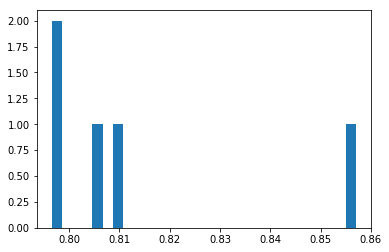

In [16]:
#photos_data, N, labels, photo_filenames, n_classes, h, w = read_photo_data(sample=200)
fft_feature_vector = get_fft_feat_vector(photo_filenames, './Fungi Pics/', fft=True)
best_scores = []
warnings.filterwarnings("ignore")
for i in range(5):
    print("Running trial RF+FFT+PCA", i+1)
    fft_train_vectors, fft_test_vectors, fft_train_labels, fft_test_labels = train_test_split(fft_feature_vector, labels, test_size=0.50)
    clf = pca_iter_rand_for(runtime=300)
    clf.fit(fft_train_vectors, fft_train_labels, fft_test_vectors, fft_test_labels)
    pred_labels = clf.predict(fft_test_vectors)
    best_scores.append(f1_score(fft_test_labels, pred_labels, average='weighted'))
    print(f1_score(fft_test_labels, pred_labels, average='weighted'))
get_f_score_stats(best_scores)

Time to make feature vectors: 53.11714696884155
2516582512
Running trial 1
0.23843971631205674 0
             precision    recall  f1-score   support

Actinomucor       0.00      0.00      0.00         4
    Clade 1       0.00      0.00      0.00         1
    Clade 2       0.00      0.00      0.00         5
    Clade 3       0.00      0.00      0.00         5
    Clade 6       0.00      0.00      0.00         8
    Clade 7       0.00      0.00      0.00        26
    Clade 8       0.00      0.00      0.00        10
      Mucor       0.41      1.00      0.58        41

avg / total       0.17      0.41      0.24       100

[[ 0  0  0  0  0  0  0  4]
 [ 0  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  5]
 [ 0  0  0  0  0  0  0  5]
 [ 0  0  0  0  0  0  0  8]
 [ 0  0  0  0  0  0  0 26]
 [ 0  0  0  0  0  0  0 10]
 [ 0  0  0  0  0  0  0 41]]
Mean: 0.23843971631205674
Median: 0.23843971631205674
Count: 3
Standard Deviation: 0.0
Threshold score: 0.23843971631205674
0.2594021164021164 0


KeyboardInterrupt: 

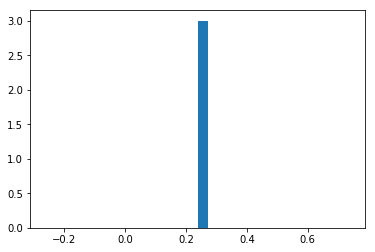

In [17]:
photos_data, N, labels, photo_filenames, n_classes, h, w = read_photo_data(sample=200)
fft_feature_vector = get_fft_feat_vector(photo_filenames, './Fungi Pics/', fft=False)
best_scores = []
for i in range(5):
    print("Running trial FSRF", i+1)
    fft_train_vectors, fft_test_vectors, fft_train_labels, fft_test_labels = train_test_split(fft_feature_vector, labels, test_size=0.50)
    clf = feat_select_rand_for(runtime=300)
    clf.fit(fft_train_vectors, fft_train_labels, fft_test_vectors, fft_test_labels)
    pred_labels = clf.predict(fft_test_vectors)
    best_scores.append(f1_score(fft_test_labels, pred_labels, average='weighted'))
    print(f1_score(fft_test_labels, pred_labels, average='weighted'))
get_f_score_stats(best_scores)

In [12]:
#photos_data, N, labels, photo_filenames, n_classes, h, w = read_photo_data(sample=200)
fft_feature_vector = get_fft_feat_vector(photo_filenames, './Fungi Pics/')
best_scores = []
for i in range(5):
    print("Running trial ANN+FFT", i+1)
    fft_train_vectors, fft_test_vectors, fft_train_labels, fft_test_labels = train_test_split(fft_feature_vector, labels, test_size=0.50)
    clf = clf = MLPClassifier(solver='lbfgs', alpha=1e-2, hidden_layer_sizes=60)
    clf.fit(fft_train_vectors, fft_train_labels)
    pred_labels = clf.predict(fft_test_vectors)
    best_scores.append(f1_score(fft_test_labels, pred_labels, average='weighted'))
    print(f1_score(fft_test_labels, pred_labels, average='weighted'))
    print(time.time()-start)
    print(classification_report(fft_test_labels, pred_labels))
    print(confusion_matrix(fft_test_labels, pred_labels))
get_f_score_stats(best_scores)


Time to make feature vectors: 144.53687930107117
2516582512
Running trial ANN+FFT 1


NameError: name 'MLPClassifier' is not defined

In [ ]:
best_scores = []
#photos_data, N, labels, photo_filenames, n_classes, h, w = read_photo_data(sample=10)
#fft_feature_vector = get_fft_feat_vector(photo_filenames, './Fungi Pics/')
for i in range(5):
    print("Running trial ANN+PCA+FFT", i+1)
    fft_train_vectors, fft_test_vectors, fft_train_labels, fft_test_labels = train_test_split(fft_feature_vector, labels, test_size=0.50)
    n_components = 20
    fft_pca = PCA(n_components=n_components, whiten=True)
    _ = fft_pca.fit(fft_train_vectors)
    pca_train_vectors = fft_pca.transform(fft_train_vectors)
    pca_test_vectors = fft_pca.transform(fft_test_vectors)
    clf = clf = MLPClassifier(solver='lbfgs', alpha=1e-2, hidden_layer_sizes=60)
    clf.fit(pca_train_vectors, fft_train_labels)
    pred_labels = clf.predict(pca_test_vectors)
    best_scores.append(f1_score(fft_test_labels, pred_labels, average='weighted'))
    print(f1_score(fft_test_labels, pred_labels, average='weighted'))
    print(classification_report(fft_test_labels, pred_labels))
    print(confusion_matrix(fft_test_labels, pred_labels))
get_f_score_stats(best_scores)

In [15]:
fft_feature_vector = get_fft_feat_vector(photo_filenames, './Fungi Pics/', fft=False)
best_scores = []
for i in range(5):
    print("Running trial ANN", i+1)
    fft_train_vectors, fft_test_vectors, fft_train_labels, fft_test_labels = train_test_split(fft_feature_vector, labels, test_size=0.50)
    clf = clf = MLPClassifier(solver='lbfgs', alpha=1e-2, hidden_layer_sizes=60)
    clf.fit(fft_train_vectors, fft_train_labels)
    pred_labels = clf.predict(fft_test_vectors)
    best_scores.append(f1_score(fft_test_labels, pred_labels, average='weighted'))
    print(f1_score(fft_test_labels, pred_labels, average='weighted'))
    print(time.time()-start)
    print(classification_report(fft_test_labels, pred_labels))
    print(confusion_matrix(fft_test_labels, pred_labels))
get_f_score_stats(best_scores)

Time to make feature vectors: 55.23473620414734
2516582512
Running trial ANN 1


MemoryError: 

In [ ]:
fft_feature_vector = get_fft_feat_vector(photo_filenames, './Fungi Pics/', fft=False)
best_scores = []
for i in range(5):
    print("Running trial ANN+PCA", i+1)
    fft_train_vectors, fft_test_vectors, fft_train_labels, fft_test_labels = train_test_split(fft_feature_vector, labels, test_size=0.50)
    n_components = 20
    fft_pca = PCA(n_components=n_components, whiten=True)
    _ = fft_pca.fit(fft_train_vectors)
    pca_train_vectors = fft_pca.transform(fft_train_vectors)
    pca_test_vectors = fft_pca.transform(fft_test_vectors)
    clf = clf = MLPClassifier(solver='lbfgs', alpha=1e-2, hidden_layer_sizes=60)
    clf.fit(pca_train_vectors, fft_train_labels)
    pred_labels = clf.predict(pca_test_vectors)
    best_scores.append(f1_score(fft_test_labels, pred_labels, average='weighted'))
    print(f1_score(fft_test_labels, pred_labels, average='weighted'))
    print(classification_report(fft_test_labels, pred_labels))
    print(confusion_matrix(fft_test_labels, pred_labels))
get_f_score_stats(best_scores)

In [ ]:
best_scores = []
for i in range(5):
    print("Running trial SVM+PCA", i+1)
    fft_train_vectors, fft_test_vectors, fft_train_labels, fft_test_labels = train_test_split(fft_feature_vector, labels, test_size=0.50)
    start = time.time()
    n_components = 20
    fft_pca = PCA(n_components=n_components, whiten=True)
    _ = fft_pca.fit(fft_train_vectors)
    pca_train_vectors = fft_pca.transform(fft_train_vectors)
    pca_test_vectors = fft_pca.transform(fft_test_vectors)
    param_grid = {'C': [10, 1e2, 1e3, 5e3, 1e4, 5e4, 1e5],
                  'gamma': [0.00001, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
    clf = clf.fit(pca_train_vectors, fft_train_labels)
    pickle.dump(clf, open("hyphal_image_classifier.obj", "wb"))
    end = time.time()
    print("Runtime:", end-start)
    pred_labels = clf.predict(pca_test_vectors)
    print(f1_score(fft_test_labels, pred_labels, average='weighted'))
    print(n_components, classification_report(fft_test_labels, pred_labels))

In [ ]:
best_scores = []
for i in range(5):
    print("Running trial SVM", i+1)
    fft_train_vectors, fft_test_vectors, fft_train_labels, fft_test_labels = train_test_split(fft_feature_vector, labels, test_size=0.50)
    start = time.time()
    param_grid = {'C': [10, 1e2, 1e3, 5e3, 1e4, 5e4, 1e5],
                  'gamma': [0.00001, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
    clf = clf.fit(fft_train_vectors, fft_train_labels)
    pickle.dump(clf, open("hyphal_image_classifier.obj", "wb"))
    end = time.time()
    print("Runtime:", end-start)
    pred_labels = clf.predict(fft_test_vectors)
    print(f1_score(fft_test_labels, pred_labels, average='weighted'))
    print(n_components, classification_report(fft_test_labels, pred_labels))

In [ ]:
fft_feature_vector = get_fft_feat_vector(photo_filenames, './Fungi Pics/', fft=True)
best_scores = []
for i in range(5):
    print("Running trial SVM+FFT+PCA", i+1)
    fft_train_vectors, fft_test_vectors, fft_train_labels, fft_test_labels = train_test_split(fft_feature_vector, labels, test_size=0.50)
    start = time.time()
    n_components = 20
    fft_pca = PCA(n_components=n_components, whiten=True)
    _ = fft_pca.fit(fft_train_vectors)
    pca_train_vectors = fft_pca.transform(fft_train_vectors)
    pca_test_vectors = fft_pca.transform(fft_test_vectors)
    param_grid = {'C': [10, 1e2, 1e3, 5e3, 1e4, 5e4, 1e5],
                  'gamma': [0.00001, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
    clf = clf.fit(pca_train_vectors, fft_train_labels)
    pickle.dump(clf, open("hyphal_image_classifier.obj", "wb"))
    end = time.time()
    print("Runtime:", end-start)
    pred_labels = clf.predict(pca_test_vectors)
    print(f1_score(fft_test_labels, pred_labels, average='weighted'))
    print(n_components, classification_report(fft_test_labels, pred_labels))

In [ ]:
best_scores = []
for i in range(5):
    print("Running trial SVM+FFT", i+1)
    fft_train_vectors, fft_test_vectors, fft_train_labels, fft_test_labels = train_test_split(fft_feature_vector, labels, test_size=0.50)
    start = time.time()
    param_grid = {'C': [10, 1e2, 1e3, 5e3, 1e4, 5e4, 1e5],
                  'gamma': [0.00001, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
    clf = clf.fit(fft_train_vectors, fft_train_labels)
    pickle.dump(clf, open("hyphal_image_classifier.obj", "wb"))
    end = time.time()
    print("Runtime:", end-start)
    pred_labels = clf.predict(fft_test_vectors)
    print(f1_score(fft_test_labels, pred_labels, average='weighted'))
    print(n_components, classification_report(fft_test_labels, pred_labels))